In [2]:
cd ..

d:\research\fedmiss_bench


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
import pandas as pd
from src.loaders.load_data import load_data
from collections import OrderedDict
import numpy as np

In [4]:
from sklearn.preprocessing import KBinsDiscretizer
X = np.random.choice([0, 1], size=(100, 1))
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample = None)
est.fit_transform(X)

array([[9.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [9.],
       [0.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [9.],
       [9.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [0.],
       [9.],
       [9.],

## Functions

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_heatmap(df, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt=".1f")
    plt.show()

In [6]:
def avg_correlation(df):
    avg_correlation_cols = list(OrderedDict(df.corr().abs().mean().sort_values(ascending=False).to_dict()).items())
    features = set(df.columns.tolist()[:-1])
    avg_correlation_cols = [col for col in avg_correlation_cols if col[0] in features]
    return avg_correlation_cols

In [7]:
from sklearn.cluster import KMeans
def kbins(data, data_config):

    est = KMeans(n_clusters=10, random_state=0)

    X = data.iloc[:, data_config['split_col_idx']].values
    X = est.fit_predict(X)
    
    return X

## Codrna

In [7]:
df, data_config = load_data('codrna')
show_heatmap(df,  figsize = (6,4))
print(avg_correlation(df))
print(data_config)

In [38]:
avg_cols = avg_correlation(df)
avg_cols = [col[0] for col in avg_cols]
split_col_idx = [df.columns.tolist().index(col) for col in avg_cols]
split_col_idx

In [63]:
cl = kbins(df, data_config)
np.unique(cl, return_counts=True)

In [41]:
data_config

## HHP

In [46]:

############################################################################################################
# Load data
# members
df_members = pd.read_csv('./data/HHP_herritage_health/Members.csv')
df_members['Sex'] = df_members['Sex'].map({'M': 1, 'F': 0})
df_members['AgeAtFirstClaim'] = df_members['AgeAtFirstClaim'].map({
    '0-9': 5,
    '10-19': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80+': 90
})

# drug and lab
df_drug = pd.read_csv('./data/HHP_herritage_health/DrugCount.csv')
df_drug['DrugCount'] = df_drug['DrugCount'].map({'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7+': 10})
df_lab = pd.read_csv('./data/HHP_herritage_health/LabCount.csv')
df_lab['LabCount'] = df_lab['LabCount'].map(
    {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10+': 12}
)

# days
df_days_y2 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y2.csv')
df_days_y2['Year'] = 'Y1'
df_days_y3 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y3.csv')
df_days_y3['Year'] = 'Y2'

df_days = pd.concat([df_days_y2, df_days_y3])

df_claims = pd.read_csv('./data/HHP_herritage_health/Claims.csv')

# divide by provider
# providers = df_claims['ProviderID'].value_counts().iloc[: 10].index.tolist()
# df_claims = df_claims[df_claims['ProviderID'].isin(providers)]
# print(df_claims.shape)

df_claims = pd.merge(df_claims, df_members, on='MemberID', how='left')
df_claims = pd.merge(df_claims, df_drug, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_lab, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_days, on=['MemberID', 'Year'], how='left')
df_claims = df_claims[df_claims['DaysInHospital'].notna()]
print(df_claims.shape)

#################################################################################################################
# Feature engineering
# drop missing age and sex
df_claims = df_claims[df_claims['AgeAtFirstClaim'].notna()].copy()
df_claims = df_claims[df_claims['Sex'].notna()].copy()
df_claims = df_claims[df_claims['DSFS'].notna()].copy()

# transform categorical columns
def transform1(row):
    if pd.isna(row):
        return 'None'
    else:
        return str(int(row))
    
df_claims['ProviderID'] = df_claims['ProviderID'].map(transform1)
df_claims['Vendor'] = df_claims['Vendor'].map(transform1)
df_claims['PCP'] = df_claims['PCP'].map(transform1)

# handle missing values for categorical columns
df_claims['ProcedureGroup'] = df_claims['ProcedureGroup'].fillna('None', inplace=False)
df_claims['Specialty'] = df_claims['Specialty'].fillna('None', inplace=False)
df_claims['PrimaryConditionGroup'] = df_claims['PrimaryConditionGroup'].fillna('None', inplace=False)
df_claims['PlaceSvc'] = df_claims['PlaceSvc'].fillna('None', inplace=False)

# encode number of columns
df_claims['CharlsonIndex'] = df_claims['CharlsonIndex'].map({'0': 0, '1-2': 1.5, '3-4': 3.5, '5+': 7})
df_claims['PayDelay'] = df_claims['PayDelay'].apply(lambda row: int(row) if row != '162+' else 200)
df_claims['LengthOfStay'] = df_claims['LengthOfStay'].map({
    '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6, '1- 2 weeks': 10, '2- 4 weeks': 21, '4- 8 weeks': 42,
})
df_claims['DSFS'] = df_claims['DSFS'].map({
    '0- 1 month': 1, '1- 2 months': 2, '2- 3 months': 3, '3- 4 months': 4, '4- 5 months': 5, '5- 6 months': 6, 
    '6- 7 months': 7, '7- 8 months': 8, '8- 9 months': 9, '9-10 months': 10, '10-11 months': 11, '11-12 months': 12
})

# filter all large claims
df_claims = df_claims[df_claims['DaysInHospital'] > 0].copy()
print(df_claims.shape)

# fill mean values for drug and lab counts
df_claims['DrugCount'] = df_claims['DrugCount'].fillna(df_claims['DrugCount'].mean(), inplace=False)
df_claims['LabCount'] = df_claims['LabCount'].fillna(df_claims['LabCount'].mean(), inplace=False)

# drop length of stay
df_claims = df_claims.drop(columns=['LengthOfStay'])

#########################################################################################################################
# Feature selection
# numerical features
def feature_agg(df, key):
    ret = df.groupby(['MemberID', 'Year']).agg(
        **{
            key+'_mean': pd.NamedAgg(column=key, aggfunc='mean'),
            key+'_std': pd.NamedAgg(column=key, aggfunc='std'),
            key+'_max': pd.NamedAgg(column=key, aggfunc='max'),
            key+'_min': pd.NamedAgg(column=key, aggfunc='min'),
        }
    )

    ret[f'{key}_range'] = ret[f'{key}_max'] - ret[f'{key}_min']
    ret = ret.reset_index()
    ret = ret.drop(columns=[f'{key}_min'])
    
    df = pd.merge(df, ret, on=['MemberID', 'Year'], how='left')
    df = df.drop(columns=[key])
    
    return df

df_claims = feature_agg(df_claims, 'DSFS')
df_claims = feature_agg(df_claims, 'PayDelay')
df_claims = feature_agg(df_claims, 'CharlsonIndex')
df_claims = feature_agg(df_claims, 'DrugCount')
df_claims = feature_agg(df_claims, 'LabCount')

def feature_agg2(df, key):
    df = df.groupby(['MemberID', 'Year']).agg(key).nunique().reset_index(name = key+'_counts')
    df = pd.merge(df_claims, df, on = ['MemberID', 'Year'], how = 'left')
    return df

df_claims = feature_agg2(df_claims, 'ProviderID')
df_claims = feature_agg2(df_claims, 'Vendor')
df_claims = feature_agg2(df_claims, 'PCP')
df_claims = feature_agg2(df_claims, 'Specialty')
df_claims = feature_agg2(df_claims, 'PlaceSvc')
df_claims = feature_agg2(df_claims, 'PrimaryConditionGroup')
df_claims = feature_agg2(df_claims, 'ProcedureGroup')
ret = df_claims.groupby(['MemberID', 'Year']).size().reset_index(name = 'claim_counts')
df_claims = pd.merge(df_claims, ret, on = ['MemberID', 'Year'], how = 'left')

df_claims.fillna(0, inplace=True)

# categoorical one-hot features
top_k = 2
for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup']:
    top_k_cols = pd.get_dummies(df_claims[col]).corrwith(df_claims['DaysInHospital']).abs().sort_values(ascending = False)[:top_k]
    dummies = pd.get_dummies(df_claims[col])[top_k_cols.index]
    dummies.columns = [f'{col}_{idx}' for idx in range(len(dummies.columns))]
    df_claims = pd.concat([df_claims, dummies], axis = 1)
    df_claims.drop(columns = [col], inplace = True)
    
df_claims = df_claims.drop(columns = ['MemberID', 'ProviderID', 'Vendor', 'PCP', 'Year'])

#########################################################################################################################
# Split data
# columns
num_cols = ['AgeAtFirstClaim']
for col in ['CharlsonIndex', 'PayDelay', 'DrugCount', 'LabCount', 'DSFS']:
    num_cols += [f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_range']
for col in ['ProviderID', 'Vendor', 'PCP', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'claim']:
    num_cols += [f'{col}_counts']
print(len(num_cols))

cat_cols = ['Sex', 'SupLOS', 'ClaimsTruncated']
cat_cols += [f'{col}_{idx}' for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'] for idx in range(top_k)]
print(len(cat_cols))

target = 'DaysInHospital'

# sample data
df_claims_sample = df_claims.sample(n = 20000, random_state=42)

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])
scaler = MinMaxScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])

# reorder target to be num cols, cat cols and target
df_claims_sample = df_claims_sample[num_cols + cat_cols + [target]]

print(df_claims_sample.shape)

data = df_claims_sample

avg_correlation_cols = avg_correlation(data)
avg_correlation_cols = [col[0] for col in avg_correlation_cols if col[0] in num_cols]
avg_correlation_cols = [col for col in avg_correlation_cols][:int(data.shape[1]*0.3)]

# data config
data_config = {
    'target': target,
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
    'split_col_idx': [data.columns.tolist().index(col) for col in avg_correlation_cols],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in cat_cols],
    "num_cols": len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

In [9]:
# import json
# data.to_csv('./data/HHP_herritage_health/data_cleaned.csv', index=False)
# with open('./data/HHP_herritage_health/data_config.json', 'w') as f:
#     json.dump(data_config, f)

In [47]:
data.shape

In [12]:
data_config['split_col_idx']

In [20]:
avg_correlation(data[num_cols])

In [19]:
data[num_cols].corrwith(data['DaysInHospital']).abs().sort_values(ascending = False)

In [6]:
data_config

In [58]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = df_claims_sample[num_cols]
y = df_claims_sample[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

In [56]:
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]).fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)), np.sqrt(mean_squared_log_error(y_test, y_pred)))

In [59]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

## California Housing

In [53]:
from sklearn.preprocessing import PowerTransformer
def outlier_remove_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[col] >= (Q1 - 1.5 * IQR)) & (data[col] <= (Q3 + 1.5 * IQR))]
    return data

def convert_gaussian(data, col):
    pt = PowerTransformer()
    data[col] = pt.fit_transform(data[col].values.reshape(-1, 1)).flatten()
    return data

In [73]:
from sklearn.datasets import fetch_california_housing, fetch_kddcup99
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
housing = fetch_california_housing()
data = pd.DataFrame(data=housing.data, columns=housing.feature_names)
target_col = 'MedHouseVal'
data[target_col] = housing.target

# drop missing values
print(data.shape)
data = data.dropna()
print(data.shape)

# remove outliers
data = outlier_remove_iqr(data, 'AveRooms')
data = outlier_remove_iqr(data, 'AveBedrms')
data = outlier_remove_iqr(data, 'Population')
data = outlier_remove_iqr(data, 'AveOccup')

# gaussian transform
data = convert_gaussian(data, 'MedInc')

num_cols = data.columns.tolist()[:-1]

scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.shape)

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [0, 2, 5],
    'ms_col_idx': list(range(len(num_cols))),
    'obs_col_idx': [4, 7],
    'num_cols': len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

print(data_config)

(20640, 9)
(20640, 9)
(17309, 9)
{'target': 'MedHouseVal', 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'split_col_idx': [0, 2, 5], 'ms_col_idx': [0, 1, 2, 3, 4, 5, 6, 7], 'obs_col_idx': [4, 7], 'num_cols': 8, 'task_type': 'regression', 'clf_type': 'none', 'data_type': 'tabular'}


In [72]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

<Axes: >

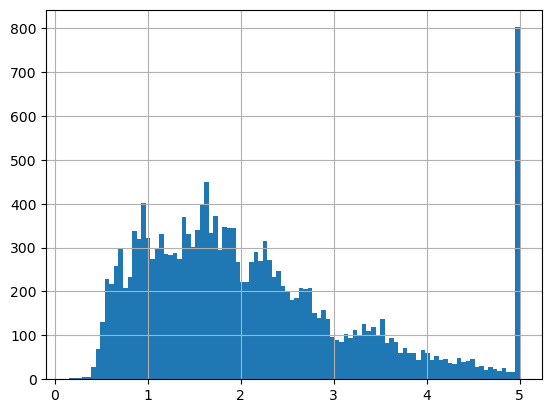

In [76]:
data[target_col].hist(bins=100)

In [74]:
data.to_csv('./data/california/data_cleaned.csv', index=False)
import json
with open('./data/california/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [62]:
data[num_cols].corrwith(data[target_col]).abs().sort_values(ascending = False)

MedInc        0.664471
AveRooms      0.348928
AveOccup      0.300296
Latitude      0.144745
HouseAge      0.113715
AveBedrms     0.079084
Population    0.047934
Longitude     0.039642
dtype: float64

In [63]:
avg_correlation(data[num_cols])

[('Latitude', 0.3028299648218262),
 ('MedInc', 0.28646477855582314),
 ('AveRooms', 0.28186323119560286),
 ('Population', 0.23566774029312026),
 ('HouseAge', 0.22605015420178803),
 ('AveOccup', 0.22438995954950725),
 ('AveBedrms', 0.1939950364378315)]

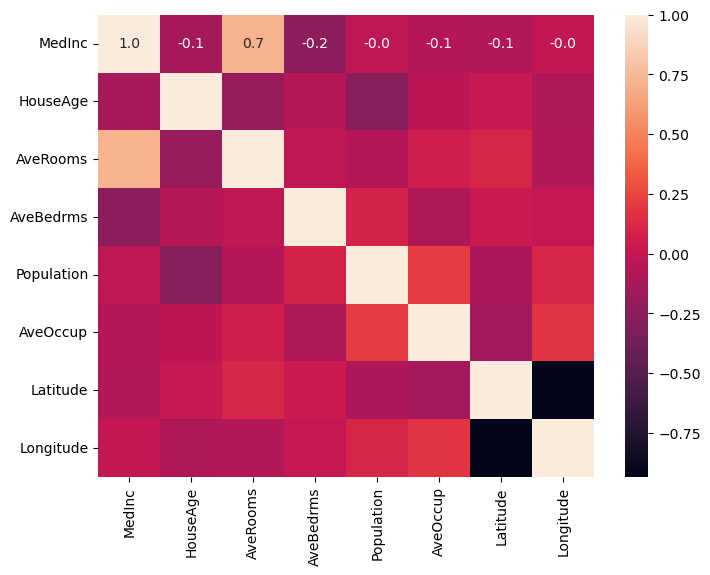

In [71]:
show_heatmap(data[num_cols])

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data[num_cols]
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 0.97413237
Iteration 2, loss = 0.45499365
Iteration 3, loss = 0.32533590
Iteration 4, loss = 0.28918070
Iteration 5, loss = 0.27170242
Iteration 6, loss = 0.25921498
Iteration 7, loss = 0.25179445
Iteration 8, loss = 0.24613219
Iteration 9, loss = 0.23848991
Iteration 10, loss = 0.23326281
Iteration 11, loss = 0.23049667
Iteration 12, loss = 0.22712086
Iteration 13, loss = 0.22382020
Iteration 14, loss = 0.22039476
Iteration 15, loss = 0.21756251
Iteration 16, loss = 0.21669183
Iteration 17, loss = 0.21452886
Iteration 18, loss = 0.21177884
Iteration 19, loss = 0.21107140
Iteration 20, loss = 0.21204991
Iteration 21, loss = 0.21017200
Iteration 22, loss = 0.20922645
Iteration 23, loss = 0.20517622
Iteration 24, loss = 0.20462825
Iteration 25, loss = 0.20369707
Iteration 26, loss = 0.20428438
Iteration 27, loss = 0.20535756
Iteration 28, loss = 0.20225805
Iteration 29, loss = 0.20209686
Iteration 30, loss = 0.20007093
Iteration 31, loss = 0.20116552
Iteration 32, los